In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from comet_ml import Experiment

experiment = Experiment(project_name='dibco', auto_param_logging=False)

COMET INFO: old comet version (2.0.8) detected. current: 2.0.9 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/augustc/dibco/53cad37b4d65433a8a1b8bdaa0c1964f



# SConvNet + Discriminator

The idea is to train SConvNet with pairs $(X,y)$ where $X$ is a large patch from the original image centered at pixel $p$ and $y$ a smaller patch from the ground truth centered on $p$. After that, training is made like an adversarial framework with a discriminator $D$ that classifies patch $y$ into real or not. Discriminator $D$ is trained with triples $(X,y',y)$, where $X$ is a large path of the image centered on $p'$, $y'$ is a smaller patch from the ground truth or generated from the SConvNet also centered on $p'$ , and $y$ is $0$ if $y'$ is from SConvNet or $1$ if $y'$ is from the ground truth.

In [3]:
l_patch = 45
s_patch = 17
batch_norm = True
epochs = 101
lr_dcg = 0.0004
lr_dsc = 0.0002
reg_l2 = 0.01
batch_size = 64

params = {'Large_patch': l_patch, 
          'Small_patch': s_patch, 
          'Batch_norm': batch_norm,
          'Epochs': epochs,
          'dsc_lr': lr_dsc,
          'adv_lr': lr_dcg,
          'reg_l2': reg_l2,
          'batch_size': batch_size}
experiment.log_parameters(params)

### Generator

In [4]:
from networks.models import SConvNet

gen_nn = SConvNet(l_patch - s_patch + 1, batch_norm=batch_norm, model_name='SConvNetGAN', reg_l2=reg_l2, n_channels=3)
gen_nn.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 8)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
batc

### Discriminator

In [5]:
from networks.models import Discriminator

disc_nn = Discriminator(l_patch, s_patch, n_channels=3)
disc_nn.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_img (InputLayer)       (None, None, None, 3 0                                            
__________________________________________________________________________________________________
crop (Cropping2D)               (None, None, None, 3 0           original_img[0][0]               
__________________________________________________________________________________________________
generate_img (InputLayer)       (None, None, None, 2 0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, None, None, 5 0           crop[0][0]                  

### DCGAN

In [6]:
from networks.models import DCGAN

disc_nn.trainable = False

dcgan_nn = DCGAN(l_patch, s_patch, G=gen_nn, D=disc_nn, n_channels=3)
dcgan_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
SConvNetGAN (Model)             (None, None, None, 2 346818      input_2[0][0]                    
__________________________________________________________________________________________________
D (Model)                       (None, None, None, 1 25185       input_2[0][0]                    
                                                                 SConvNetGAN[1][0]                
Total params: 372,003
Trainable params: 345,602
Non-trainable params: 26,401
__________________________________________________________________________________________________


/home/augustocms/Masters/studies/notebooks/Image-to-Image-Transformation-Learning/networks/models.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="DCGAN", outputs=[<tf.Tenso...)`
  DCGAN = Model(inputs=inp_g, output=[gen_img, d_out], name='DCGAN')


In [7]:
from keras.optimizers import Adam

opt_dcg = Adam(lr=lr_dcg, beta_1=0.5)
opt_disc = Adam(lr=lr_dsc, beta_1=0.5)

loss_gen = 'binary_crossentropy'
loss_dcgan = 'binary_crossentropy'
loss_disc = 'binary_crossentropy'

gen_nn.compile(optimizer=opt_disc, loss=loss_gen)
dcgan_nn.compile(optimizer=opt_dcg, loss=loss_dcgan)

disc_nn.trainable = True
disc_nn.compile(optimizer=opt_disc, loss=loss_disc, metrics=['accuracy'])

## DIBCO
### Loading data

In [8]:
import numpy as np

dir_dibco = "/home/augustocms/scratch/DIBCO/"
dir_imgs = dir_dibco

with open(dir_dibco + 'train_full.txt') as f:
    x = f.read().splitlines()
imgs = np.array(x)

with open(dir_dibco + 'val.txt') as f:
    x = f.read().splitlines()
val_imgs = np.array(x)

with open(dir_dibco + 'test.txt') as f:
    x = f.read().splitlines()
test_imgs = np.array(x)

print(imgs[0])

2009/H01.bmp 2009/H01.tiff


## Load Data

Viewing the data and adjusting lists for DataGen

In [ ]:
import scipy.misc as m
import matplotlib.pyplot as plt

images, gt, mask = [], [], []
tl_img, tl_gt, tl_mask = [],[],[]

for i, line in enumerate(imgs):
    names = line.split()
    img = m.imread(dir_dibco + names[0])
    seg = m.imread(dir_dibco + names[1])
    
    tl_img.append(names[0])
    tl_gt.append(names[1])

/home/augustocms/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/home/augustocms/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
len(tl_img)

86

Adjusting lists of validation data for the specified format of DataGen

In [ ]:
vl_img, vl_gt, vl_mask = [], [], []
for line in val_imgs:
    names = line.split()
    vl_img.append(names[0])
    vl_gt.append(names[1])

In [ ]:
len(vl_img)

20

## Preprocessing images

In [ ]:
from skimage.exposure import equalize_adapthist
from utils.image_utils import preprocess_imgs

def swt(img):
    pass

def add_noise(img, mean=0, std=1):
    noisy_img = img + np.random.normal(mean,std,img.shape)
    noisy_img = np.clip(noisy_img, 0, 255)
    return noisy_img

def clahe(img):
    return equalize_adapthist(img, kernel_size=s_patch)

tl_imgs, dir_imgs = preprocess_imgs(clahe, tl_img, dir_dibco, verbose=0)
vl_imgs = preprocess_imgs(clahe, vl_img, dir_dibco, verbose=0)[0]

/home/augustocms/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [ ]:
from utils.datagen import DataGenPatches

# Dicts for DataGen
paths_to_files = {'images': dir_imgs, 'gt': dir_dibco, 'mask': None}
tdata_lists = {'images': tl_imgs, 'gt':tl_gt, 'mask':None}
vdata_lists = {'images': vl_imgs[:10], 'gt':vl_gt[:10], 'mask':None}

# DataGen
tDataGenP = DataGenPatches(l_patch, s_patch, data_lists=tdata_lists, paths=paths_to_files, window=29, load_all=False, batch_size=batch_size, sampling=0.05)
# vDataGenP = DataGenPatches(l_patch, s_patch, data_lists=vdata_lists, paths=paths_to_files, window=29, load_all=False, batch_size=256, imsize=(584, 565))

tDataGenP.__len__()

237

## Training

In [ ]:
import os

# Creating directories for weights and models
if not os.path.exists('weights/'):
    os.makedirs('weights/')
    
if not os.path.exists('pretrained_models/'):
    os.makedirs('pretrained_models/')
    
if not os.path.exists('experiments/dibco/'):
    os.makedirs('experiments/dibco/')
    
step=0

  0%|          | 0/237 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


100%|██████████| 237/237 [00:53<00:00,  4.43it/s, D_loss1=0.972, D_loss2=1.1, Acc_R=0.582, Acc_G=0.434, DCGAN_loss=0.992] 


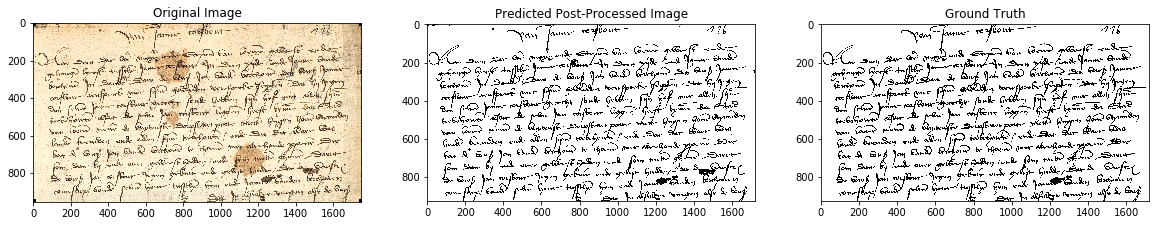

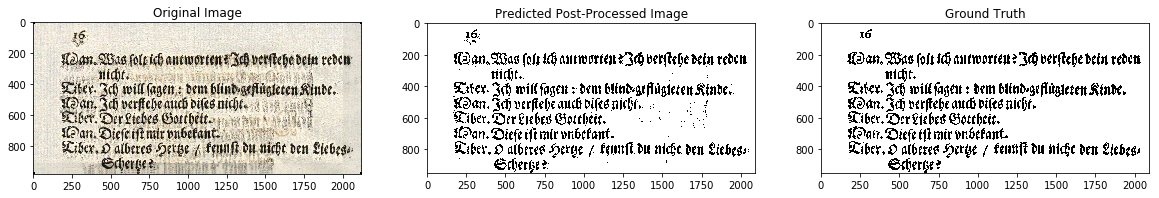

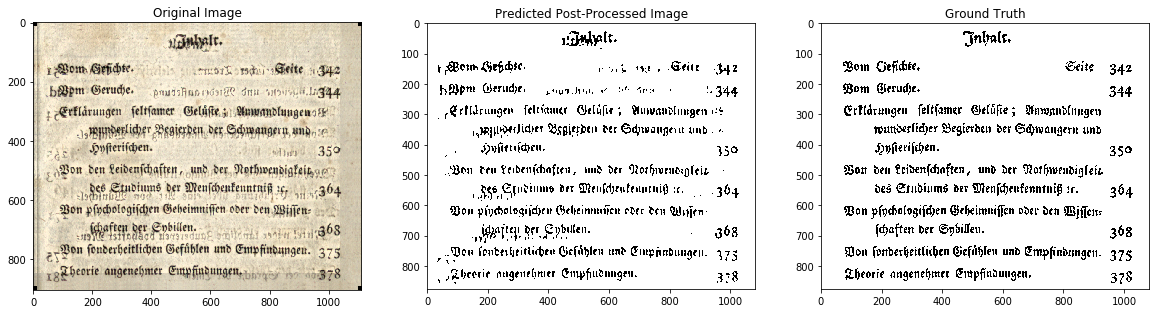

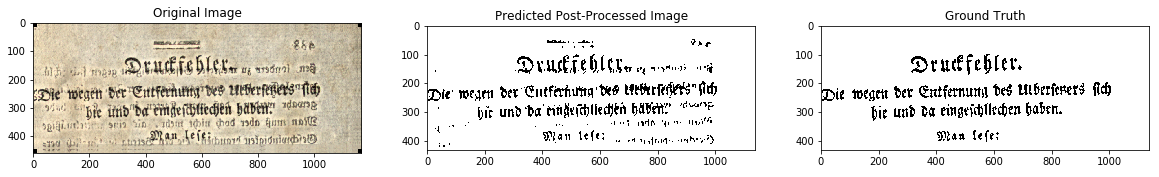

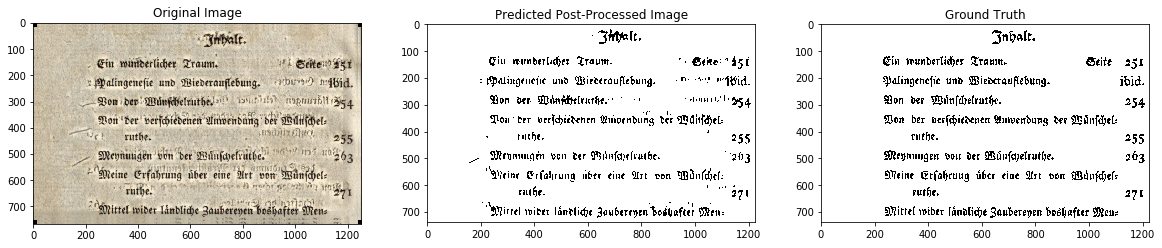

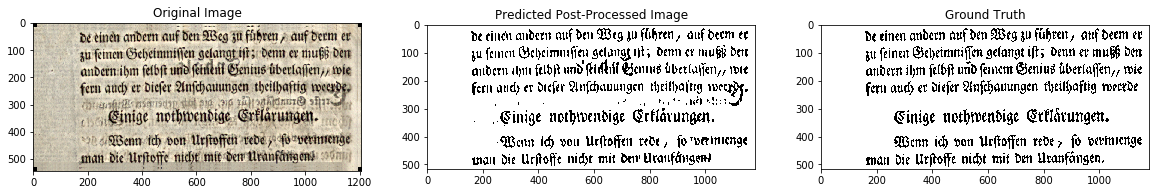

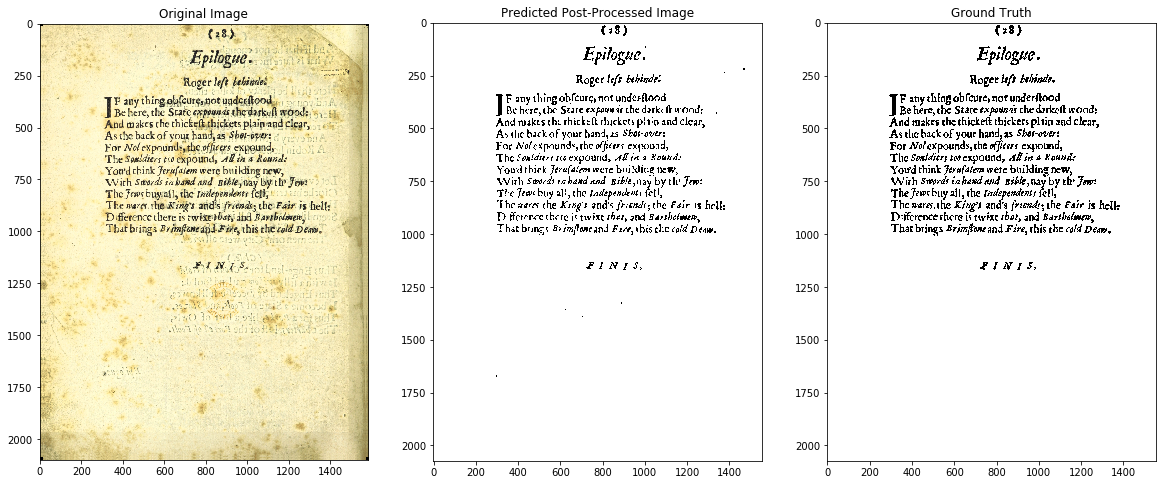

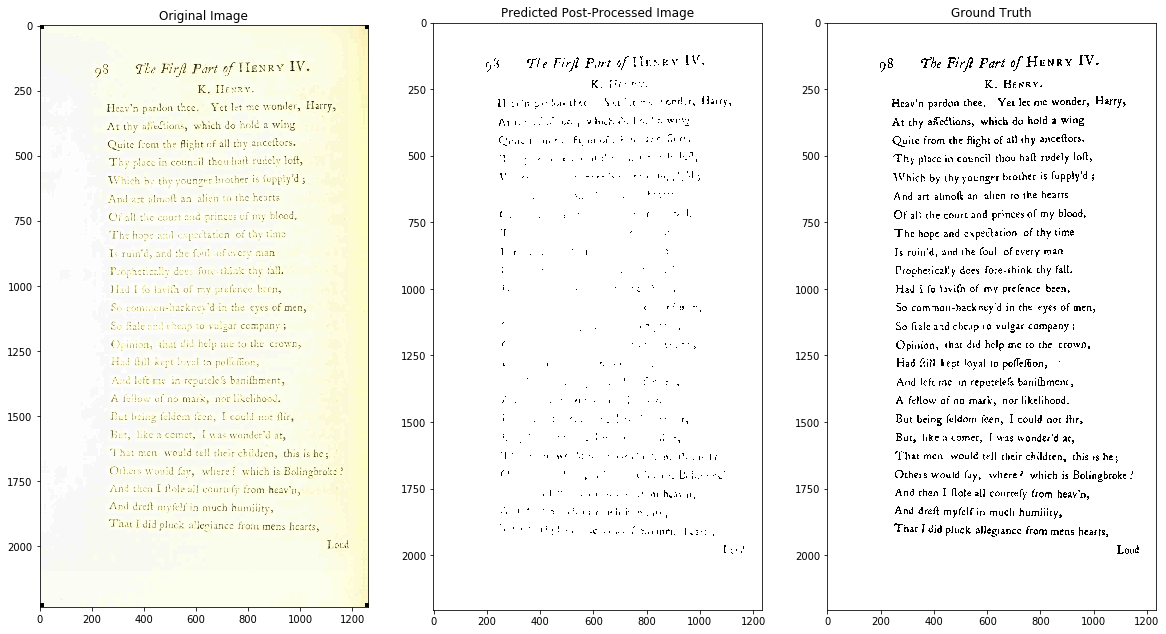

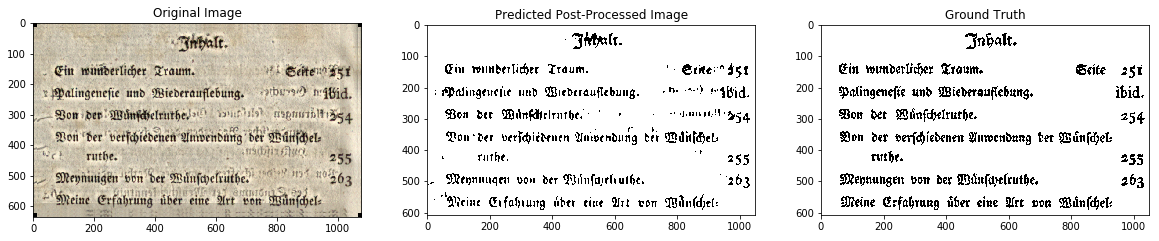

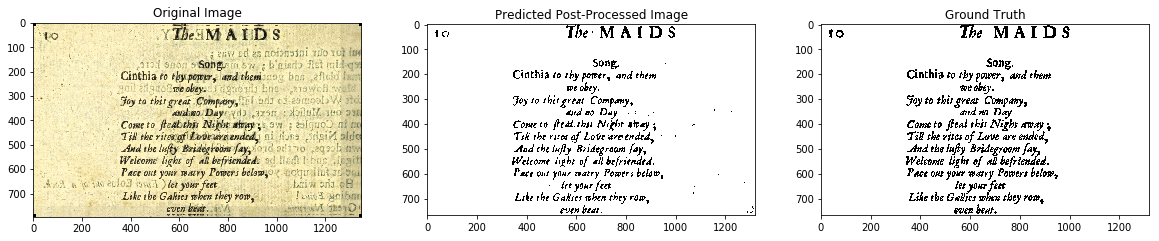

 40%|████      | 95/237 [00:19<00:28,  4.99it/s, D_loss1=0.745, D_loss2=0.748, Acc_R=0.48, Acc_G=0.43, DCGAN_loss=0.747]  

In [ ]:
from keras.utils import generic_utils
from utils.image_utils import plot_predicted_images_list
from utils.evaluation import precision, recall, f1, acc, pseudoFM, psnr
from tqdm import tqdm
from keras import backend as K

PSNR_old = -1

for j in range(epochs):
    tDataGenP.on_epoch_end()
    bs = tDataGenP.batch_size
    t = tqdm(range(len(tDataGenP)))
    dl1, dl2, dcgl, gl, acc1, acc2 = 0, 0, 0, 0, 0, 0
#     grad_D, grad_G = 0,0
    for i in t:
        experiment.set_step(step)
        step = step+1
        
        # Get data from DataGen
        X_orig, y_orig = tDataGenP[i]
        # Create fake data
        n = X_orig.shape[0]
        X_toG = X_orig.copy()
        y_T = y_orig.copy()
        y_G = gen_nn.predict(X_toG)
        
        # Data for discriminator D
#         X_Dtrain = [X_orig,y]
#         y_Dtrain = np.zeros((n,1,1,1))
#         y_Dtrain[n//2:,:,:, 0] = -0.3 + (np.random.random((n//2,1,1))*0.5)    #Label smoothing and flipping
#         y_Dtrain[:n//2,:,:, 0] = 0.7 + (np.random.random((n//2,1,1))*0.5)   #Label smoothing and flipping
#         # Train D
#         disc_nn.trainable = True
#         D_loss = disc_nn.train_on_batch(X_Dtrain, y_Dtrain)
        
        # Training D in two batches with label flipping and smoothing
        disc_nn.trainable = True
        X_Dtrain = [X_orig, y_T]
        y_Dtrain = np.ones((n,1,1,1))
        D_loss1, acc1_b = disc_nn.train_on_batch(X_Dtrain, y_Dtrain)
        
        X_Dtrain = [X_orig, y_G]
        y_Dtrain = np.zeros((n,1,1,1))
        D_loss2, acc2_b = disc_nn.train_on_batch(X_Dtrain, y_Dtrain)
        
        # Data for generator G
        X_Gtrain = X_orig
        y_Gtrain = np.ones((n,1,1,1))
        # Freeze D
        disc_nn.trainable = False
        # Train G
        G_loss = dcgan_nn.train_on_batch(X_Gtrain, [y_orig, y_Gtrain])
        t.set_postfix({'D_loss1': D_loss1, 'D_loss2': D_loss2, 'Acc_R': acc1_b, 'Acc_G': acc2_b, 'DCGAN_loss':G_loss[0]})
        
        dl1 += D_loss1
        dl2 += D_loss2
        gl += G_loss[1]
        dcgl += G_loss[0]
        acc1 += acc1_b
        acc2 += acc2_b
        
        with experiment.train():
            if i%50 == 0 and i > 0:
                dl1 /= 50
                dl2 /= 50
                dcgl /= 50
                gl /= 50
                acc1 /= 50
                acc2 /= 50
                metrics = {'d_loss_R': dl1,
                           'd_loss_G': dl2,
                           'g_loss': gl,
                           'adv_loss': dcgl,
                          'acc_R': acc1,
                          'acc_G': acc2}
                experiment.log_metrics(metrics)
                dl1, dl2, dcgl, gl, acc1, acc2 = 0, 0, 0, 0, 0, 0
    
    if j % 10 == 0:
        with experiment.validate():
            imgs, gt = plot_predicted_images_list(gen_nn, vdata_lists, paths_to_files, window=l_patch-s_patch+1, mode='RGB')
            fmeasure = f1(imgs,gt, invert=True)
            prec = precision(imgs,gt, invert=True)
            rec = recall(imgs,gt, invert=True)
            #pseudoF = pseudoFM(imgs, gt, invert=True)
            PSNR = psnr(imgs, gt, invert=True)
            
            if PSNR > PSNR_old:
                gen_nn.save('pretrained_models/G_dibco.h5')
                disc_nn.save('pretrained_models/D_dibco.h5')
                dcgan_nn.save('pretrained_models/DCGAN_dibco.h5')
                PSNR_old = PSNR
                
            metrics = {
                'precision': prec,
                'recall' : rec,
                'F1': fmeasure,
             #   'pseudoF': pseudoF,
                'psnr' : PSNR
            }
            experiment.log_metrics(metrics)
            
            plt.figure(figsize=(20,30))
            for im in range(len(imgs)):
                plt.subplot(5, 2, im+1)
                image = imgs[im][0]
                plt.imshow(image, cmap='gray')
                plt.axis('off')               
            
            plt.tight_layout()
            plt.savefig(r'experiments/dibco/'+str(j)+'.png')
            experiment.log_image(r'experiments/dibco/'+str(j)+'.png')
            plt.close('all')

In [ ]:
# Creating gif of images

import imageio

filenames = [r'experiments/dibco/'+str(i)+'.png' for i in range(0,epochs,10)]
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(r'experiments/dibco/learning.gif', images, duration=0.5)

experiment.log_image('experiments/dibco/learning.gif')

In [ ]:
experiment.end()

# Comparison against SConvNet without an adversarial framework

In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
    
restartkernel()